In [1]:
using Revise
using ShipMMG
using PyPlot, PyCall
using Turing, DifferentialEquations
using CSV, Random, DataFrames, Distributions
using KernelDensity: kde
@pyimport numpy as np
@pyimport scienceplots

In [2]:
using Serialization
;

In [3]:
using Pkg

In [4]:
#ShipMMGライブラリのバージョンを確認
Pkg.status("ShipMMG")

Status `~/.julia/environments/v1.10/Project.toml`
  [37f2b0bf] ShipMMG v0.0.7


## 1.Suzakuモデルの設定(MTI提供)

### 1.1 主要目・流体力微係数の設定

In [5]:
# 模型船スケール
function get_suzaku_model_basic_params(ρ = 1025.0)
    
    L_pp = 3.50  # 船長Lpp[m]
    B = 0.57  # 船幅[m]
    d = 0.16  # 喫水[m]
    nabla = 0.7407 * L_pp * B * d # 排水量[m3] 
    x_G = 0.0112 # 重心位置[]
    D_p = 0.03373 * L_pp # プロペラ直径[m]
    m = nabla * ρ # 質量[kg]
    I_zG = m * ((0.25 * L_pp)^2)  # 慣性モーメント[kg m^2] 
    A_R = 0.0189  # 船の断面に対する舵面積比[-]
    η = 0.8023  # プロペラ直径に対する舵高さ(Dp/H)
    m_x = 0.0475 * m #(0.5 * ρ * (L_pp^2) * d)  # 付加質量x[kg]
    m_y = 0.6739 * m #(0.5 * ρ * (L_pp^2) * d)  # 付加質量y[kg]
    J_z = 0.0306 * m * (L_pp^2) #(0.5 * ρ * (L_pp^4) * d)  # 付加質量Izz[kg]
    f_α = 2.634 # 直圧力勾配係数
    ϵ = 1.345  # プロペラ・舵位置伴流係数比
    t_R = 0.084  # 操縦抵抗減少率 
    a_H = 0.054  # 舵力増加係数
    x_H = -0.388 * L_pp  # 舵力増分作用位置
    γ_R_minus = 0.225 # 整流係数
    γ_R_plus = 0.574  # 整流係数
    l_R = -0.641  # 船長に対する舵位置
    κ = 0.482  # 修正係数
    t_P = 0.180  # 推力減少率 #モデルの違い
    w_P0 = 0.40  # 有効伴流率 #モデルの違い
    x_P = -0.490  # 船長に対するプロペラ位置 #モデルの違い
    x_R = -0.500 * L_pp

    basic_params = Mmg3DofBasicParams(
        L_pp,
        B,
        d,
        x_G,
        D_p,
        m,
        I_zG,
        A_R,
        η,
        m_x,
        m_y,
        J_z,
        f_α,
        ϵ,
        t_R,
        x_R,
        a_H,
        x_H,
        γ_R_minus,
        γ_R_plus,
        l_R,
        κ,
        t_P,
        w_P0,
        x_P,
    )
    basic_params
end

function get_suzaku_model_maneuvering_params()
    k_0 = 0.3516
    k_1 = -0.3624
    k_2 = -0.1100
    R_0_dash = 0.020
    X_vv_dash = -0.0799
    X_vr_dash = 0.1016
    X_rr_dash = -0.0176
    X_vvvv_dash = 0.5704
    Y_v_dash = -0.3711
    Y_r_dash = 0.0720
    Y_vvv_dash = -1.0535
    Y_vvr_dash = 0.207
    Y_vrr_dash = -0.2556
    Y_rrr_dash = 0.0220
    N_v_dash = -0.1097
    N_r_dash = -0.0527
    N_vvv_dash = -0.0533
    N_vvr_dash = -0.2863
    N_vrr_dash = -0.0206
    N_rrr_dash = -0.0196

    maneuvering_params = Mmg3DofManeuveringParams(
        k_0,
        k_1,
        k_2,
        R_0_dash,
        X_vv_dash,
        X_vr_dash,
        X_rr_dash,
        X_vvvv_dash,
        Y_v_dash,
        Y_r_dash,
        Y_vvv_dash,
        Y_vvr_dash,
        Y_vrr_dash,
        Y_rrr_dash,
        N_v_dash,
        N_r_dash,
        N_vvv_dash,
        N_vvr_dash,
        N_vrr_dash,
        N_rrr_dash,
    )
    maneuvering_params
end
;

In [6]:
basic_params = get_suzaku_model_basic_params()
maneuvering_params = get_suzaku_model_maneuvering_params()
;

In [7]:
L_pp = basic_params.L_pp
;

## 2.観測データ

## 3.MCMC

### 3.1 ダウンサンプリング・ノイズの付与

In [8]:
duration = 20
sampling_rate = 20

#データの読み込み
df = CSV.read("/home/hirukawa/myenv/Lab/MCMC-MPC_KVLCC2/20degmodel.csv", DataFrame)
df = df[completecases(df), :]
sampling = Int((length(df[:,1])-1)/(duration*sampling_rate))
df = df[1:sampling:end,:]

time_list = df[!,"time"]
u = df[!,"u"]
v = df[!,"v"]
r = df[!,"r"]
δ = df[!,"δ"]
n_p = df[!,"n_p"]
x = df[!,"x"]
y = df[!,"y"]
ψ = df[!,"ψ"]

u_obs = u .+ rand(Normal(0, 0.02), length(u))
v_obs = v .+ rand(Normal(0, 0.01), length(v))
r_obs = r .+ rand(Normal(0, 0.02), length(r))

df = DataFrame(
    time = time_list,
    u = u_obs,
    v = v_obs,
    r = r_obs,
)

CSV.write("suzaku_model_obs_data.csv", df)

data = ShipData(time_list, u_obs, v_obs, r_obs, r.*0, r.*0, r.*0, δ, n_p)

ShipData{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}}
  time: Array{Float64}((401,)) [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  19.55, 19.6, 19.65, 19.7, 19.75, 19.8, 19.85, 19.9, 19.95, 20.0]
  u: Array{Float64}((401,)) [0.7006442782906541, 0.6807843431613417, 0.7040521363158572, 0.6892852652671374, 0.6968084847073165, 0.6881614220577656, 0.6522648171619373, 0.6762480870970629, 0.6967462935293217, 0.6938632291148393  …  0.477882782526018, 0.4468889377244683, 0.48450593466561415, 0.4571259451102076, 0.4109620335053752, 0.4257805543699774, 0.4241648993334404, 0.4322659607097278, 0.45066155644936096, 0.4559412766639541]
  v: Array{Float64}((401,)) [-0.009669831859712269, -0.00741058000533291, 0.005039283511749322, -0.0015315578123753853, 0.001681762705980791, 0.0016004316868185563, -8.792401528000834e-5, 0.016248485150982712, -0.007885304640519208, -0.02950319248552

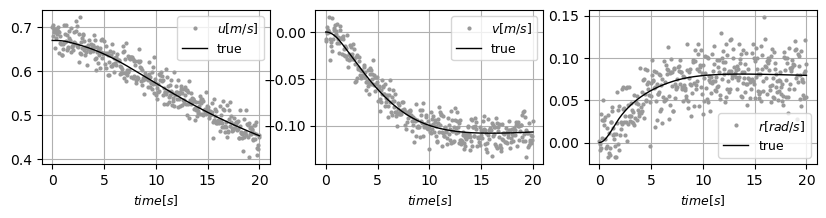

In [9]:
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1, 3, 1)
ax.plot(time_list[:], u_obs[:],label=L"u[m/s]", "o", c="0.6", markersize=2)
ax.plot(time_list[:], u[:], label="true", "-", c="k", linewidth=1)
ax.legend(frameon=true, fontsize=9)
ax.set_xlabel(L"time[s]", fontsize=9)
ax.grid()

ax = fig.add_subplot(1, 3, 2)
ax.plot(time_list[:], v_obs[:],label=L"v[m/s]", "o", c="0.6", markersize=2)
ax.plot(time_list[:], v[:], label="true", "-", c="k", linewidth=1)
ax.legend(frameon=true, fontsize=9)
ax.set_xlabel(L"time[s]", fontsize=9)
ax.grid()

ax = fig.add_subplot(1, 3, 3)
ax.plot(time_list[:], r_obs[:],label=L"r[rad/s]", "o", c="0.6", markersize=2)
ax.plot(time_list[:], r[:], label="true", "-", c="k", linewidth=1)
ax.legend(frameon=true, fontsize=9)
ax.set_xlabel(L"time[s]", fontsize=9)
ax.grid()
display(fig)

### 3.2 MCMCの実行

In [10]:
function MCMC()
    global chain_array, coefficient_list
    # 事前分布＝一様分布の定義
    R_0_dash_under, R_0_dash_upper = -0.25, 0.75
    X_vv_dash_under, X_vv_dash_upper = -0.40,0.40
    X_vr_dash_under, X_vr_dash_upper = -0.438,0.382
    X_rr_dash_under, X_rr_dash_upper = -0.148,0.092
    X_vvvv_dash_under, X_vvvv_dash_upper = -2.80,2.80
    Y_v_dash_under, Y_v_dash_upper = -0.75, 0.25
    Y_r_dash_under, Y_r_dash_upper = -0.25,0.35
    Y_vvv_dash_under, Y_vvv_dash_upper = -10.00,6.00
    Y_vvr_dash_under, Y_vvr_dash_upper = -4.25,2.75
    Y_vrr_dash_under, Y_vrr_dash_upper = -2.25,0.75
    Y_rrr_dash_under, Y_rrr_dash_upper = -0.2,0.12
    N_v_dash_under, N_v_dash_upper = -0.30,0.10
    N_r_dash_under, N_r_dash_upper = -0.15,0.05
    N_vvv_dash_under, N_vvv_dash_upper = -0.95,0.85
    N_vvr_dash_under, N_vvr_dash_upper = -1.50,0.50
    N_vrr_dash_under, N_vrr_dash_upper = -0.60,0.60
    N_rrr_dash_under, N_rrr_dash_upper = -0.09,0.03

    R_0_dash_prior_dist_setting = Uniform(R_0_dash_under, R_0_dash_upper)
    X_vv_dash_prior_dist_setting = Uniform(X_vv_dash_under, X_vv_dash_upper)
    X_vr_dash_prior_dist_setting = Uniform(X_vr_dash_under, X_vr_dash_upper)
    X_rr_dash_prior_dist_setting = Uniform(X_rr_dash_under, X_rr_dash_upper)
    X_vvvv_dash_prior_dist_setting = Uniform(X_vvvv_dash_under, X_vvvv_dash_upper)
    Y_v_dash_prior_dist_setting = Uniform(Y_v_dash_under, Y_v_dash_upper)
    Y_r_dash_prior_dist_setting = Uniform(Y_r_dash_under, Y_r_dash_upper)
    Y_vvv_dash_prior_dist_setting = Uniform(Y_vvv_dash_under, Y_vvv_dash_upper)
    Y_vvr_dash_prior_dist_setting = Uniform(Y_vvr_dash_under, Y_vvr_dash_upper)
    Y_vrr_dash_prior_dist_setting = Uniform(Y_vrr_dash_under, Y_vrr_dash_upper)
    Y_rrr_dash_prior_dist_setting = Uniform(Y_rrr_dash_under, Y_rrr_dash_upper)
    N_v_dash_prior_dist_setting = Uniform(N_v_dash_under, N_v_dash_upper)
    N_r_dash_prior_dist_setting = Uniform(N_r_dash_under, N_r_dash_upper)
    N_vvv_dash_prior_dist_setting = Uniform(N_vvv_dash_under, N_vvv_dash_upper)
    N_vvr_dash_prior_dist_setting = Uniform(N_vvr_dash_under, N_vvr_dash_upper)
    N_vrr_dash_prior_dist_setting = Uniform(N_vrr_dash_under, N_vrr_dash_upper)
    N_rrr_dash_prior_dist_setting = Uniform(N_rrr_dash_under, N_rrr_dash_upper)

    # MCMC探索に使う初期値
    start_vals = push!(rand(3)
                ,maneuvering_params.R_0_dash
                ,maneuvering_params.X_vv_dash
                ,maneuvering_params.X_vr_dash
                ,maneuvering_params.X_rr_dash
                ,maneuvering_params.X_vvvv_dash
                ,maneuvering_params.Y_v_dash
                ,maneuvering_params.Y_r_dash
                ,maneuvering_params.Y_vvv_dash
                ,maneuvering_params.Y_vvr_dash
                ,maneuvering_params.Y_vrr_dash
                ,maneuvering_params.Y_rrr_dash
                ,maneuvering_params.N_v_dash
                ,maneuvering_params.N_r_dash
                ,maneuvering_params.N_vvv_dash
                ,maneuvering_params.N_vvr_dash
                ,maneuvering_params.N_vrr_dash
                ,maneuvering_params.N_rrr_dash
                );

    # サンプリング回数
    sampling_n = 1000;

    # MCMCの実行
    model = []
    model = create_model_for_mcmc_sample_mmg(
            data,
            basic_params,
            maneuvering_params.k_0,
            maneuvering_params.k_1,
            maneuvering_params.k_2,
            ρ=1025.0,
            σ_u_prior_dist = Uniform(0.0, 1.0), #InverseGamma(1,1),
            σ_v_prior_dist = Uniform(0.0, 1.0), #InverseGamma(1,1),
            σ_r_prior_dist = Uniform(0.0, 1.0), #InverseGamma(1,1),
            R_0_dash_prior_dist = R_0_dash_prior_dist_setting,
            X_vv_dash_prior_dist = X_vv_dash_prior_dist_setting,
            X_vr_dash_prior_dist = X_vr_dash_prior_dist_setting,
            X_rr_dash_prior_dist = X_rr_dash_prior_dist_setting,
            X_vvvv_dash_prior_dist = X_vvvv_dash_prior_dist_setting,
            Y_v_dash_prior_dist = Y_v_dash_prior_dist_setting,
            Y_r_dash_prior_dist = Y_r_dash_prior_dist_setting,
            Y_vvv_dash_prior_dist = Y_vvv_dash_prior_dist_setting,
            Y_vvr_dash_prior_dist = Y_vvr_dash_prior_dist_setting,
            Y_vrr_dash_prior_dist = Y_vrr_dash_prior_dist_setting,
            Y_rrr_dash_prior_dist = Y_rrr_dash_prior_dist_setting,
            N_v_dash_prior_dist = N_v_dash_prior_dist_setting,
            N_r_dash_prior_dist = N_r_dash_prior_dist_setting,
            N_vvv_dash_prior_dist = N_vvv_dash_prior_dist_setting,
            N_vvr_dash_prior_dist = N_vvr_dash_prior_dist_setting,
            N_vrr_dash_prior_dist = N_vrr_dash_prior_dist_setting,
            N_rrr_dash_prior_dist = N_rrr_dash_prior_dist_setting,
        )

    chain = []
    chain = sample(model, NUTS(500, 0.65), MCMCThreads(), sampling_n, 1; initial_params=start_vals)

    #結果の保存
    f = open("MCMC.jis", "w")
    serialize(f, chain)
    close(f)

    chain_array = Array(chain)
    coefficient_list = DataFrame(chain_array,[:sigma_u, :sigma_v, :sigma_r, :R_0, :X_vv, :X_vr, :X_rr, :X_vvvv, :Y_v, :Y_r, :Y_vvv, :Y_vvr, :Y_vrr, :Y_rrr, :N_v, :N_r, :N_vvv, :N_vvr, :N_vrr, :N_rrr])
    CSV.write("MCMC.csv", coefficient_list)
end

MCMC (generic function with 1 method)

In [11]:
Threads.nthreads()

6

In [12]:
MCMC()

Sampling (1 threads)   0%|                              |  ETA: N/A
┌ Warning: dt(3.552713678800501e-15) <= dtmin(3.552713678800501e-15) at t=12.277547064560231, and step error estimate = 0.7067173956148084. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/hirukawa/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:599
┌ Warning: dt(3.552713678800501e-15) <= dtmin(3.552713678800501e-15) at t=12.272797165170738, and step error estimate = 0.9148846844484756. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/hirukawa/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:599
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/hirukawa/.julia/packages/Turing/HwTAU/src/inference/hmc.jl:197
┌ Warning: dt(3.552713678800501e-15) <= dtmin(3.552713678800501e-15) at t=5.33704567945776, and step error estimate = 2.304944076958994. A

"MCMC.csv"

## 4.同定結果のシミュレーション

In [13]:
#真値の取得
time_list_true = df[!,"time"]
u_true = df[!,"u"]
v_true = df[!,"v"]
r_true = df[!,"r"]
δ = df[!,"δ"] 
n_p = df[!,"n_p"]
x_true = df[!,"x_true"]
y_true = df[!,"y_true"]
ψ_true = df[!,"ψ_true"]

s_sample, s_param = size(chain_array)
num_r_sample = 300 # 微係数サンプルデータから300setランダムに抽出

predicted_random_sample = zeros(Float64, num_r_sample, 3, length(time_list_true))

for k in 1:num_r_sample
    random = rand(500:s_sample)
    p=chain_array[random, 4:end]
    #p=chain_array[(1:s_sample), 4:end] #mean用
    maneuvering_params_pre = Mmg3DofManeuveringParams(
        maneuvering_params.k_0,
        maneuvering_params.k_1,
        maneuvering_params.k_2,
        p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10],p[11],p[12],p[13],p[14],p[15],p[16],p[17],
        #mean(p[:,1]),mean(p[:,2]),mean(p[:,3]),mean(p[:,4]),mean(p[:,5]),mean(p[:,6]),mean(p[:,7]),mean(p[:,8]),mean(p[:,9]),mean(p[:,10]),mean(p[:,11]),mean(p[:,12]),mean(p[:,13]),mean(p[:,14]),mean(p[:,15]),mean(p[:,16]),mean(p[:,17]),
        )
        
    mmg_results_pre = mmg_3dof_simulate(
        basic_params,
        maneuvering_params_pre,
        time_list_true,
        δ,
        n_p,
        u0=u_true[1],
        v0=0.0,
        r0=0.0,
        ρ = 1025.0,
        algorithm=Tsit5(),
        reltol=1e-8,
        abstol=1e-8,
        )
    u_pre, v_pre, r_pre,  = mmg_results_pre
    
    predicted_random_sample[k, 1, :] = u_pre
    predicted_random_sample[k, 2, :] = v_pre
    predicted_random_sample[k, 3, :] = r_pre
end

ArgumentError: ArgumentError: column name "δ" not found in the data frame; existing most similar names are: "r", "u" and "v"

In [14]:
num_r_sample = 300
pl1 = plot()
pl2 = plot()
pl3 = plot()
for col in 1:3
    for k in 1:num_r_sample
        if col == 1
            if k == 1
                
                
                pl1 = plot(time_list_true, predicted_random_sample[k, 1, :],alpha=0.1, c="#2ca02c",label=raw"$Estimation$")
                

                pl1 = scatter!(time_list_obs, u_obs, linestyle=:dot, linecolor=:black, marker=:circle, markercolor=:white,label=raw"$Observation$",ms=2,markerstrokewidth=0.3)

                
            else
                pl1 = plot!(time_list_true, predicted_random_sample[k, 1, :],alpha=0.1, c="#2ca02c",label = "")
            
            end
    if k == num_r_sample
        pl1 = plot!(time_list_true, u_true, c="black",label=raw"$True$",ls =:dash,ylims=(1,2),ylabel = raw"$u[m/s]$", guidefont=font(20))
    end

        elseif col == 2
            if k == 1
                
                pl2 = plot(time_list_true, predicted_random_sample[k, 2, :],alpha=0.1, c="#2ca02c",label = "")

                pl2 = scatter!(time_list_obs, v_obs, linestyle=:dot, linecolor=:black, marker=:circle, markercolor=:white,ms=2,ls = 1,label = "",markerstrokewidth=0.3)

            else
                pl2 = plot!(time_list_true, predicted_random_sample[k, 2, :],alpha=0.1, c="#2ca02c",label = "")

            end
    if k == num_r_sample
        pl2 = plot!(time_list_true, v_true, c="black",label="",ls =:dash,ylims=(-0.5,0.5),ylabel = raw"$v[m/s]$", guidefont=font(20))
    end
        
        elseif col == 3
            if k == 1
                pl3 = plot(time_list_true, predicted_random_sample[k, 3, :],alpha=0.1, c="#2ca02c",label = "")

                pl3 = scatter!(time_list_obs, r_obs, linestyle=:dot, linecolor=:black, marker=:circle, markercolor=:white,ms=2,ls = 1,label = "",markerstrokewidth=0.3)

            else
                pl3 = plot!(time_list_true, predicted_random_sample[k, 3, :],alpha=0.1, c="#2ca02c",label = "")
            end
    if k == num_r_sample
        pl3 = plot!(time_list_true, r_true, c="black",label="",ls =:dash,ylims=(-0.5,0.5),ylabel = raw"$r[rad/s]$",xlabel = raw"$t[s]$",left_margin = 5Plots.mm, guidefont=font(20))

    end
            
        end
    end
end

plot(pl1,pl2,pl3,layout=(3,1),size=(800,1200))

UndefVarError: UndefVarError: `predicted_random_sample` not defined

In [15]:
pl = plot()
for k in 1:num_r_sample
    
    x_pre, y_pre, Ψ_pre = calc_position(
        time_list_true,
        predicted_random_sample[k, 1, :],
        predicted_random_sample[k, 2, :],
        predicted_random_sample[k, 3, :]
        );
    if k == 1
        plot(y_pre/L_pp, x_pre/L_pp, alpha=0.1, lc = "#2ca02c", label = raw"$Estimation$")
    else
        plot!(y_pre/L_pp, x_pre/L_pp, alpha=0.1, lc = "#2ca02c", label=false)
    end
end

plot!(y_true/L_pp, x_true/L_pp, alpha=1, color = "black", label = raw"$True$",xlims=(-5,5),ylims=(-1,50),xlabel = raw"$y/L_{pp}$",ylabel = raw"$x/L_{pp}$", guidefont=font(20),linestyle=:dash,aspect_ratio=1.0,size=(200,600))

UndefVarError: UndefVarError: `predicted_random_sample` not defined

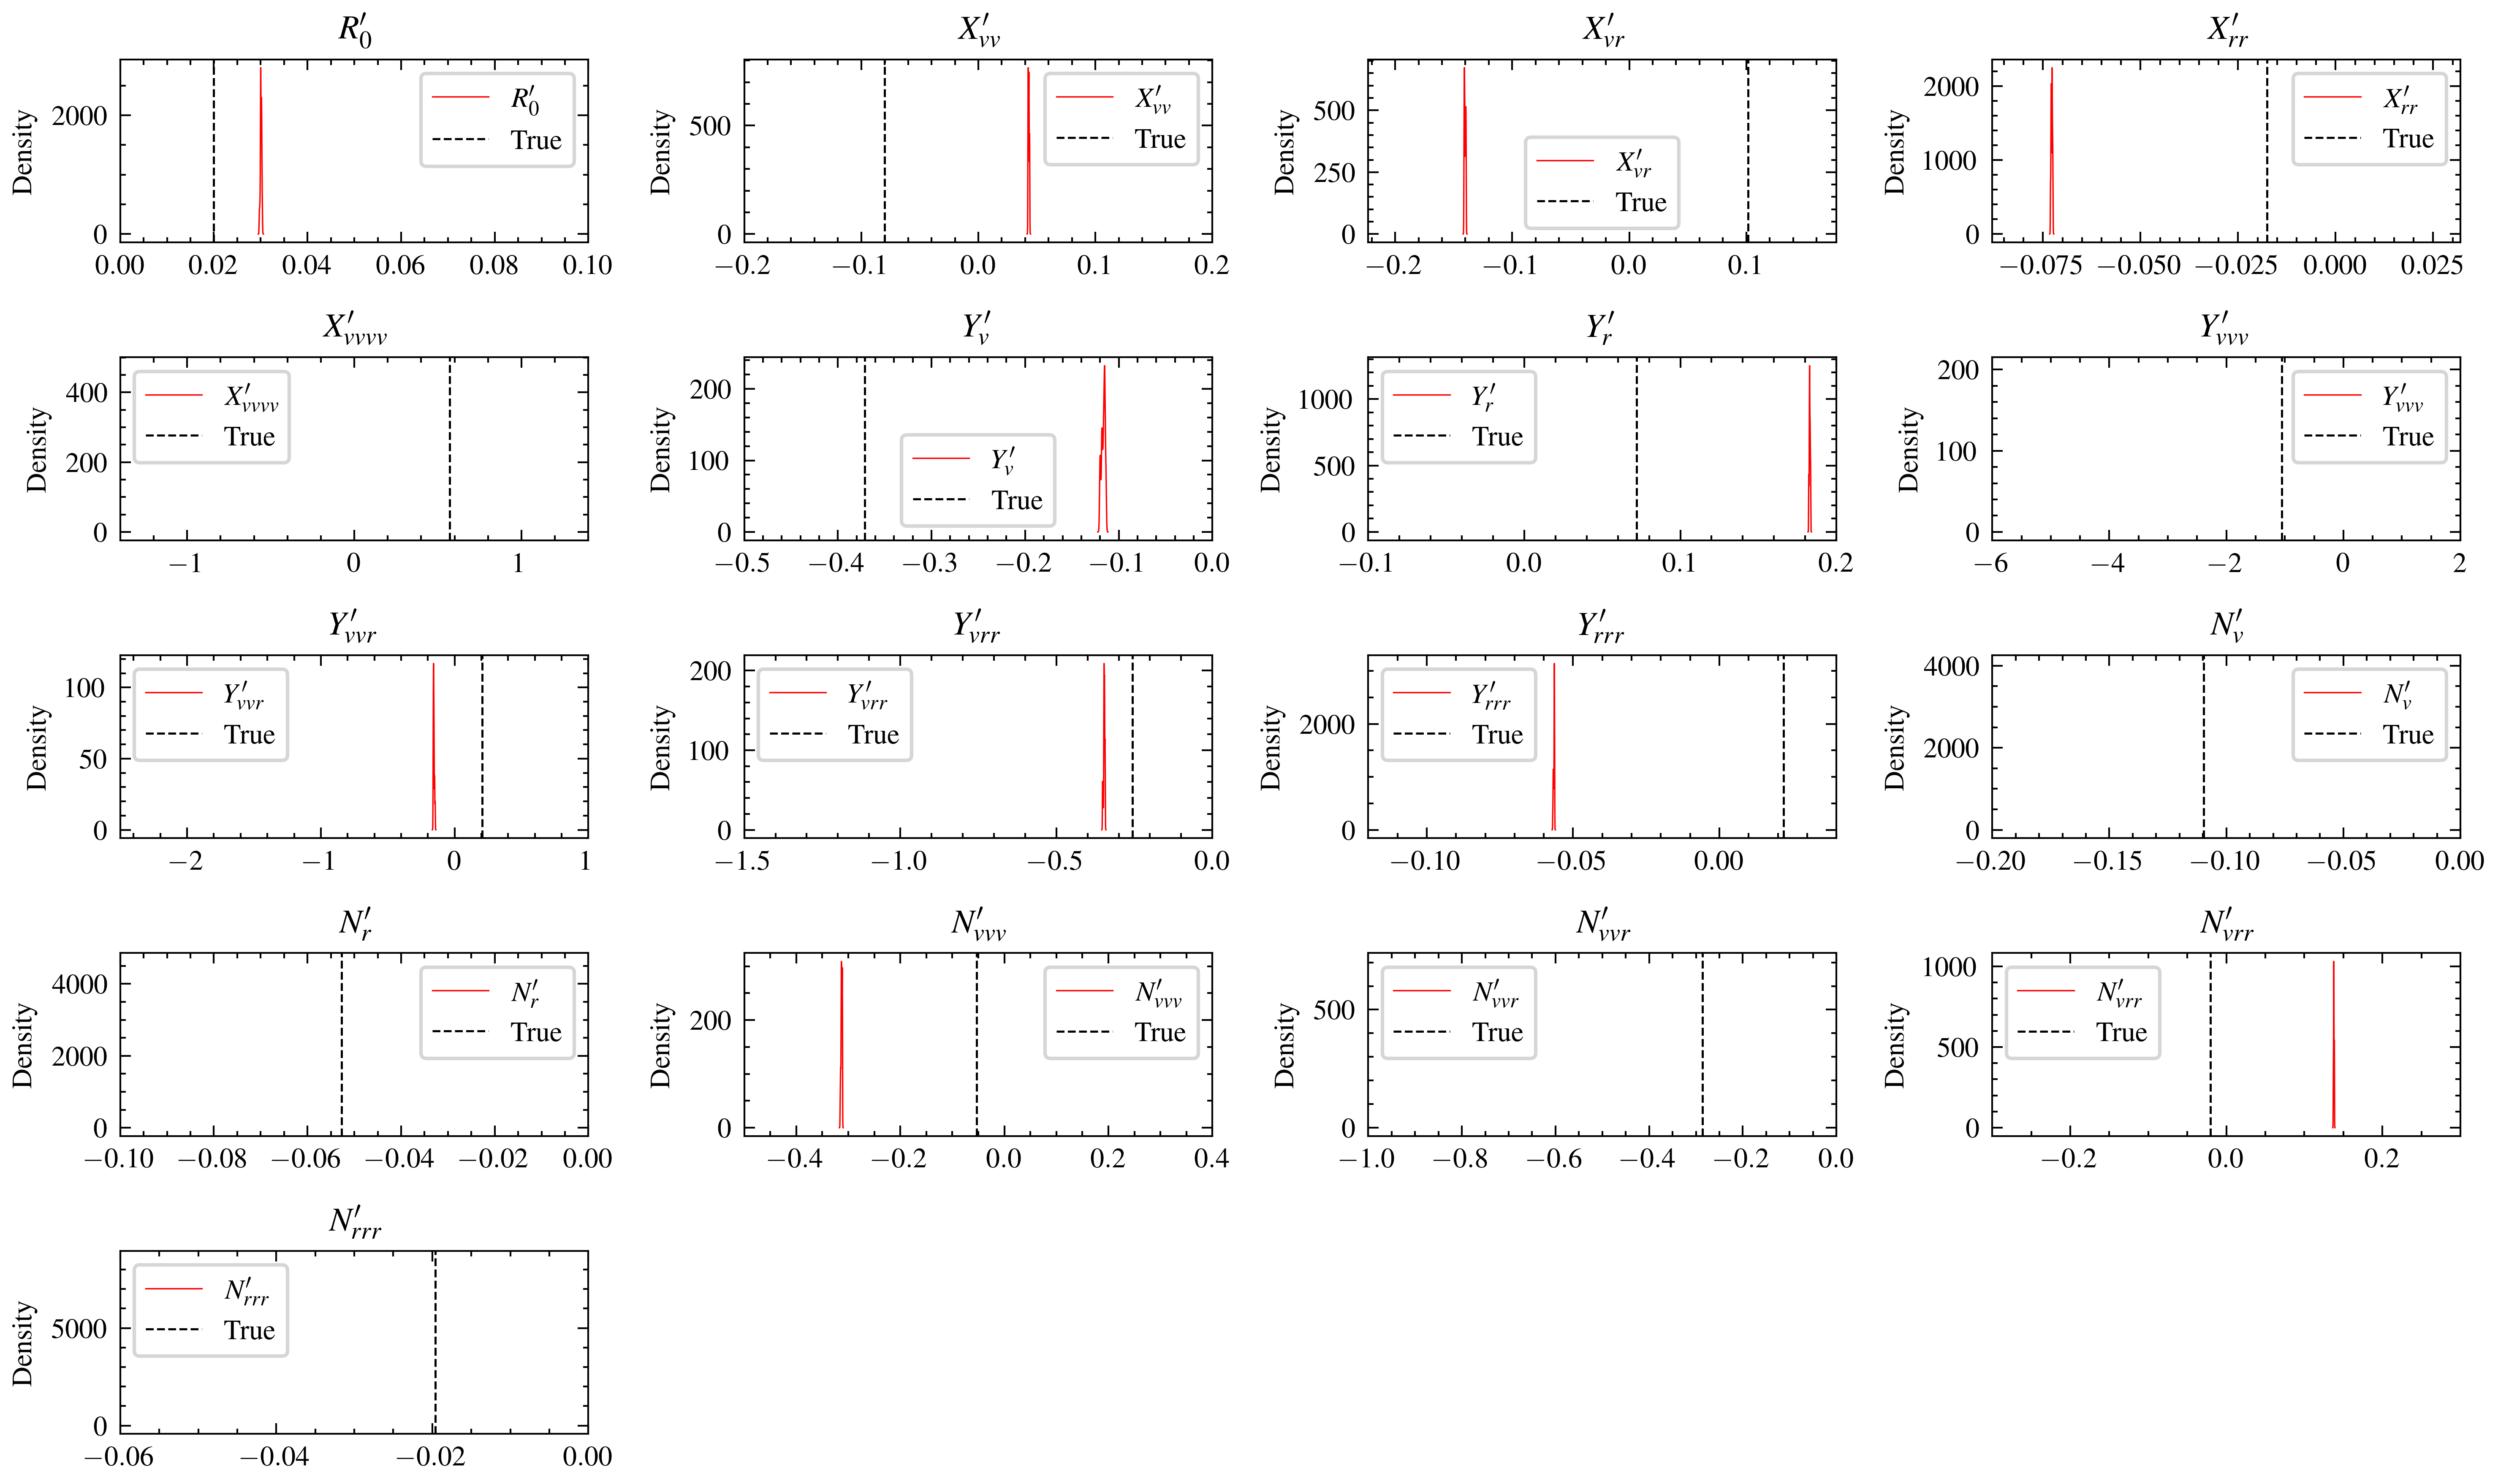

In [16]:
plt.style.use(["science", "ieee"])

# データの読み込み
data = CSV.read("./MCMC.csv", DataFrame)
fig = plt.figure(figsize=(10, 6))

# R_0_dash
R_0_posterior = data.R_0[500:1000]
kde_result = kde(R_0_posterior)
ax = fig.add_subplot(5, 4, 1)
ax.plot(kde_result.x, kde_result.density, label=L"R_0^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.020, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"R_0^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(0.00, 0.10)

# X_vv_dash
X_vv_posterior = data.X_vv[500:1000]
kde_result = kde(X_vv_posterior)
ax = fig.add_subplot(5, 4, 2)
ax.plot(kde_result.x, kde_result.density, label=L"X_{vv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.0799, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{vv}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.20, 0.20)

# X_vr_dash
X_vr_posterior = data.X_vr[500:1000]
kde_result = kde(X_vr_posterior)
ax = fig.add_subplot(5, 4, 3)
ax.plot(kde_result.x, kde_result.density, label=L"X_{vr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.1016, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{vr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.223, 0.177)

# X_rr_dash
X_rr_posterior = data.X_rr[500:1000]
kde_result = kde(X_rr_posterior)
ax = fig.add_subplot(5, 4, 4)
ax.plot(kde_result.x, kde_result.density, label=L"X_{rr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.0176, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{rr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.088, 0.032)

# X_vvvv_dash
X_vvvv_posterior = data.X_vvvv[500:1000]
kde_result = kde(X_vvvv_posterior)
ax = fig.add_subplot(5, 4, 5)
ax.plot(kde_result.x, kde_result.density, label=L"X_{vvvv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.5704, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"X_{vvvv}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-1.40, 1.40)

# Y_v_dash
Y_v_posterior = data.Y_v[500:1000]
kde_result = kde(Y_v_posterior)
ax = fig.add_subplot(5, 4, 6)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{v}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.3711, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{v}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.50, 0.00)

# Y_r_dash
Y_r_posterior = data.Y_r[500:1000]
kde_result = kde(Y_r_posterior)
ax = fig.add_subplot(5, 4, 7)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{r}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.0720, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{r}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.10, 0.20)

# Y_vvv_dash
Y_vvv_posterior = data.Y_vvv[500:1000]
kde_result = kde(Y_vvv_posterior)
ax = fig.add_subplot(5, 4, 8)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{vvv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-1.0535, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{vvv}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-6.00, 2.00)

# Y_vvr_dash
Y_vvr_posterior = data.Y_vvr[500:1000]
kde_result = kde(Y_vvr_posterior)
ax = fig.add_subplot(5, 4, 9)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{vvr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.207, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{vvr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-2.50, 1.00)

# Y_vrr_dash
Y_vrr_posterior = data.Y_vrr[500:1000]
kde_result = kde(Y_vrr_posterior)
ax = fig.add_subplot(5, 4, 10)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{vrr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.2556, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{vrr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-1.50, 0.00)

# Y_rrr_dash
Y_rrr_posterior = data.Y_rrr[500:1000]
kde_result = kde(Y_rrr_posterior)
ax = fig.add_subplot(5, 4, 11)
ax.plot(kde_result.x, kde_result.density, label=L"Y_{rrr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=0.0220, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"Y_{rrr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.12, 0.04)

# N_v_dash
N_v_posterior = data.N_v[500:1000]
kde_result = kde(N_v_posterior)
ax = fig.add_subplot(5, 4, 12)
ax.plot(kde_result.x, kde_result.density, label=L"N_{v}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.1097, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{v}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.20, 0.00)

# N_r_dash
N_r_posterior = data.N_r[500:1000]
kde_result = kde(N_r_posterior)
ax = fig.add_subplot(5, 4, 13)
ax.plot(kde_result.x, kde_result.density, label=L"N_{r}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.0527, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{r}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.10, 0.00)

# N_vvv_dash
N_vvv_posterior = data.N_vvv[500:1000]
kde_result = kde(N_vvv_posterior)
ax = fig.add_subplot(5, 4, 14)
ax.plot(kde_result.x, kde_result.density, label=L"N_{vvv}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.0533, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{vvv}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.50, 0.40)

# N_vvr_dash
N_vvr_posterior = data.N_vvr[500:1000]
kde_result = kde(N_vvr_posterior)
ax = fig.add_subplot(5, 4, 15)
ax.plot(kde_result.x, kde_result.density, label=L"N_{vvr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.2863, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{vvr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-1.00, 0.00)

# N_vrr_dash
N_vrr_posterior = data.N_vrr[500:1000]
kde_result = kde(N_vrr_posterior)
ax = fig.add_subplot(5, 4, 16)
ax.plot(kde_result.x, kde_result.density, label=L"N_{vrr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.0206, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{vrr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.30, 0.30)

# N_rrr_dash
N_rrr_posterior = data.N_rrr[500:1000]
kde_result = kde(N_rrr_posterior)
ax = fig.add_subplot(5, 4, 17)
ax.plot(kde_result.x, kde_result.density, label=L"N_{rrr}^{\prime}", c="r", linewidth=0.4)
ax.axvline(x=-0.0196, c="k", linestyle="--", label="True", linewidth=0.6)
ax.set_ylabel(L"\textrm{Density}")
ax.set_title(L"N_{rrr}^{\prime}")
ax.legend(frameon=true)
ax.set_xlim(-0.06, 0.00)

plt.tight_layout()
display(fig)